In [237]:
import pandas as pd
import matplotlib.pyplot as plt
from WindPy import w
import pyfolio as pf
import os
import datetime
import empyrical
%matplotlib inline

In [130]:
def metric(daily_ret):
    total_ret = empyrical.cum_returns_final(daily_ret)
    an_ret = empyrical.annual_return(daily_ret)
    sharpe = empyrical.sharpe_ratio(daily_ret)
    vol = empyrical.annual_volatility(daily_ret)
    maxdraw = empyrical.max_drawdown(daily_ret)
    print 'Total return: %.2f%%'%(total_ret*100)
    print 'Annual return: %.2f%%'%(an_ret*100)
    print 'Sharpe ratio: %.2f'%(sharpe)
    print 'Annual volatility: %.2f%%'%(vol*100)
    print 'Max drawdown: %.2f%%'%(maxdraw*100)

In [131]:
w.start()

.ErrorCode=0
.Data=[Already conntected!]

In [132]:
DATA_DIR = 'D:/Data/derivatives/futures/'

In [133]:
def wind2df(raw_data):
    dic = {}
    for data, field in zip(raw_data.Data, raw_data.Fields):
        dic[field.lower()] = data
    return pd.DataFrame(dic, index=raw_data.Times)

In [212]:
start_date, end_date = '2013-05-01', '2017-12-12'

In [213]:
data = w.wsd('000300.SH', 'close', start_date, end_date)

In [214]:
df = wind2df(data)

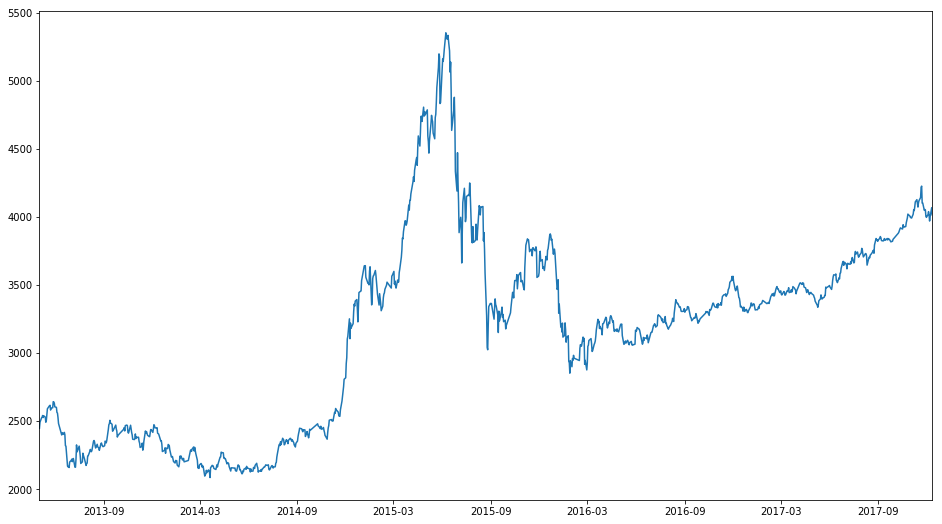

In [215]:
plt.figure(figsize=(16, 9))
df['close'].plot()

# 选取主力合约

In [216]:
fnames = [f for f in os.listdir(DATA_DIR) if f.startswith('IF')]

In [217]:
oi_df = pd.DataFrame(index=df.index)
p_df = pd.DataFrame(index=df.index)
for f in fnames:
    fname = '%s/%s'%(DATA_DIR, f)
    wind_code = f.rstrip('.xlsx')
    temp = pd.read_excel(fname)
    oi_df[wind_code] = temp['oi']
    p_df[wind_code] = temp['close']

In [218]:
idx_max = oi_df.idxmax(axis=1)

In [219]:
future_close = pd.Series(index=idx_max.index)
for index in idx_max.index:
    future_close.loc[index] = p_df.loc[index][idx_max.loc[index]]

In [220]:
df['future'] = future_close

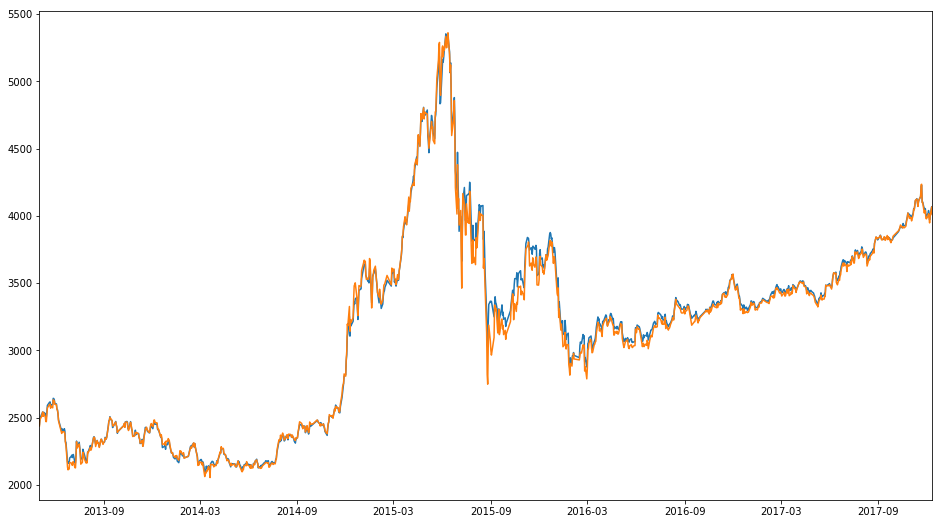

In [221]:
plt.figure(figsize=(16, 9))
df['close'].plot()
df['future'].plot()

In [222]:
df['basis'] = df['future'] - df['close']

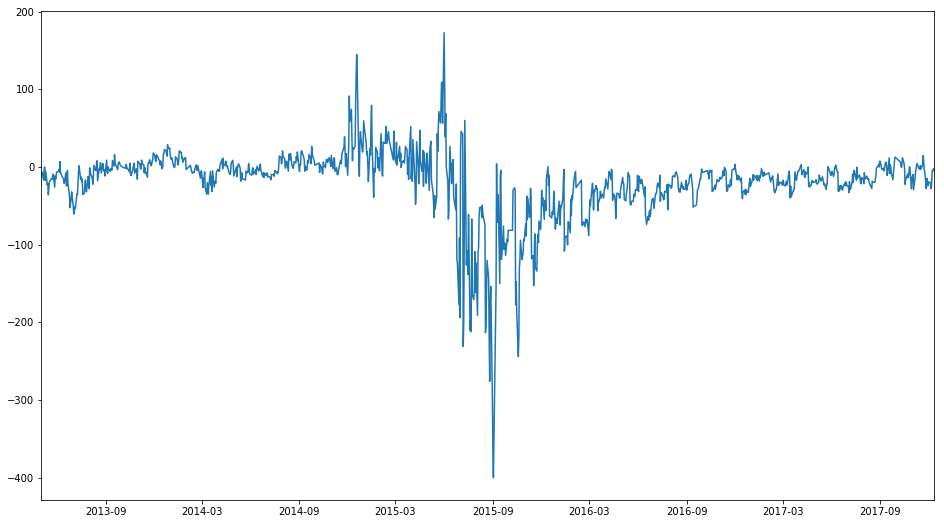

In [223]:
plt.figure(figsize=(16, 9))
df['basis'].plot()

In [224]:
df['basis diff'] = df['basis'].diff()

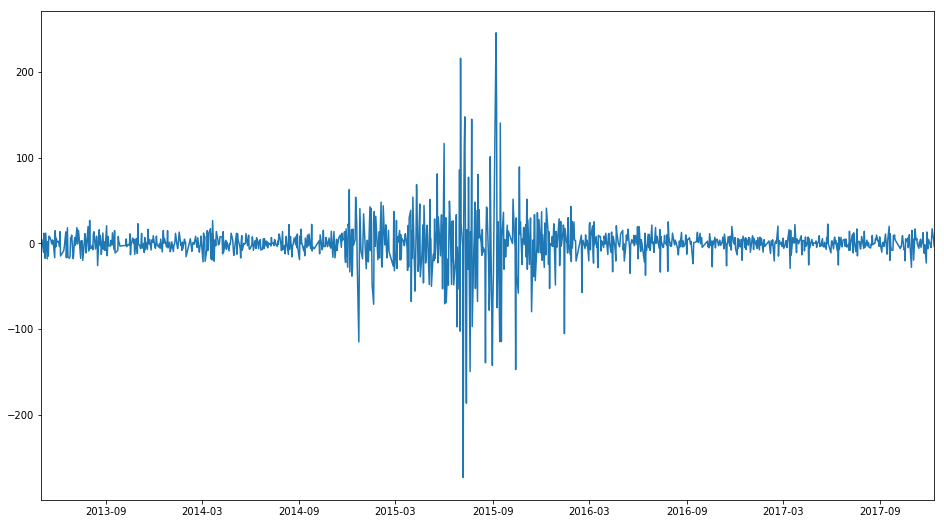

In [225]:
plt.figure(figsize=(16, 9))
df['basis diff'].plot()

In [262]:
df['short basis diff'] = df['basis diff'].rolling(window=10).mean()
df['long basis diff'] = df['basis diff'].rolling(window=125).mean()

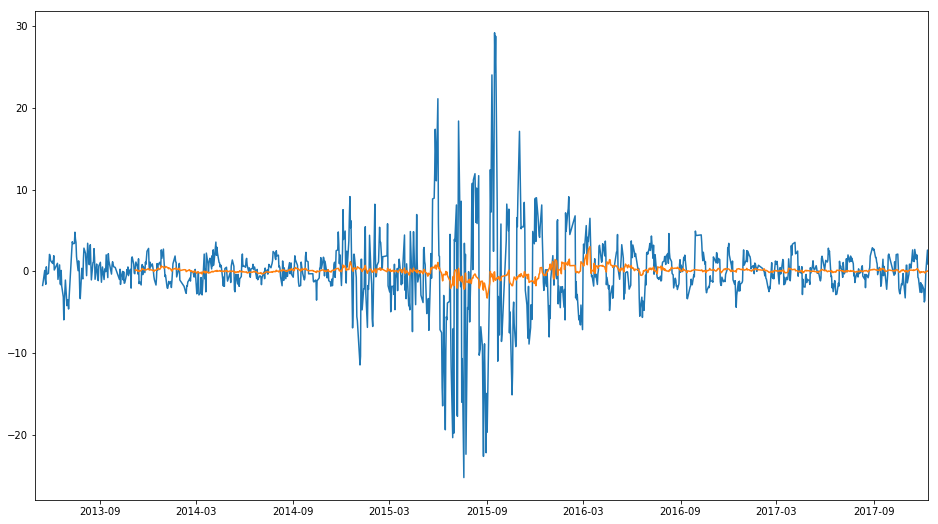

In [263]:
plt.figure(figsize=(16, 9))
df['short basis diff'].plot()
df['long basis diff'].plot()

In [264]:
strategy = df.dropna().copy()

In [265]:
bought = False
flag = 0
strategy['signal'] = 0
strategy['hold'] = 0
prev_diff = 100.
for date in strategy.index:
    strategy['signal'][date] = flag
    strategy['hold'][date] = 1 if bought else 0
    diff = df.loc[date]['short basis diff'] - df.loc[date]['long basis diff']
    if not bought and diff > 0 and prev_diff < 0:
        bought = True
        flag = 1
    elif bought and diff < 0 and prev_diff > 0:
        bought = False
        flag = -1
    else:
        flag = 0
    prev_diff = diff

C:\Users\zhangyang01\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\zhangyang01\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [266]:
strategy[strategy['signal'] != 0].shape

(245, 8)

In [267]:
ret = strategy['close'].pct_change() * strategy['hold']

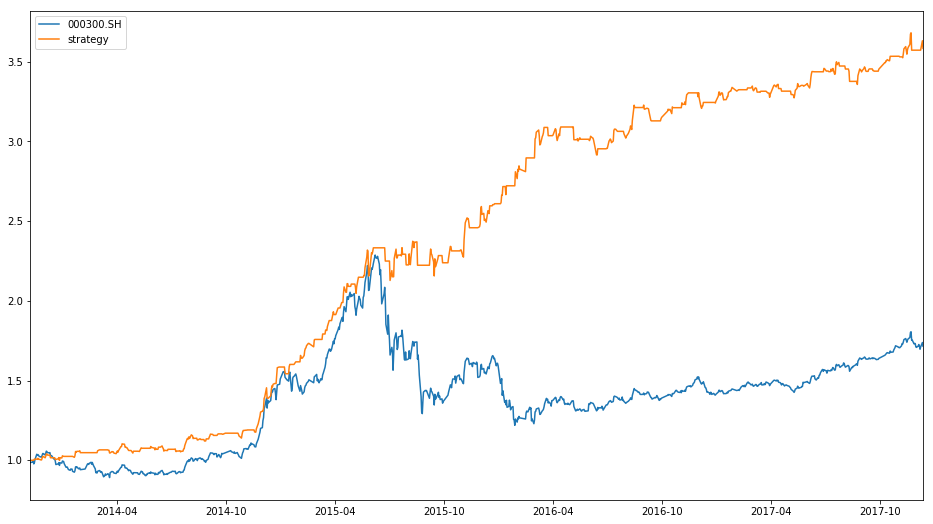

In [268]:
plt.figure(figsize=(16, 9))
(1 + strategy['close'].pct_change()).cumprod().plot(label='000300.SH')
(1 + ret).cumprod().plot(label='strategy')
plt.legend()

In [269]:
metric(ret[ret.index >= datetime.date(2016,2,1)])

Total return: 27.54%
Annual return: 14.42%
Sharpe ratio: 1.43
Annual volatility: 9.77%
Max drawdown: -5.67%


In [270]:
metric(ret)

Total return: 258.37%
Annual return: 37.81%
Sharpe ratio: 2.15
Annual volatility: 15.50%
Max drawdown: -9.17%


In [271]:
metric(df[df.index >= datetime.date(2016,2,1)]['close'].pct_change())

Total return: 38.43%
Annual return: 19.74%
Sharpe ratio: 1.38
Annual volatility: 13.78%
Max drawdown: -7.74%


In [253]:
bought = False
flag = 0
strategy['signal'] = 0
strategy['hold'] = 0
prev_diff = 100.
for date in strategy.index:
    strategy['signal'][date] = flag
    strategy['hold'][date] = 1 if bought else 0
    diff = df.loc[date]['short basis diff'] - df.loc[date]['long basis diff']
    past_return = strategy[strategy.index <= date]['close'].pct_change()[-20:].mean()
    if not bought and past_return > 0:
        bought = True
        flag = 1
    elif bought and past_return < 0:
        bought = False
        flag = -1
    else:
        flag = 0
    prev_diff = diff

C:\Users\zhangyang01\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\zhangyang01\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [254]:
strategy[strategy['signal'] != 0].shape

(92, 8)

In [255]:
ret = strategy['close'].pct_change() * strategy['hold']

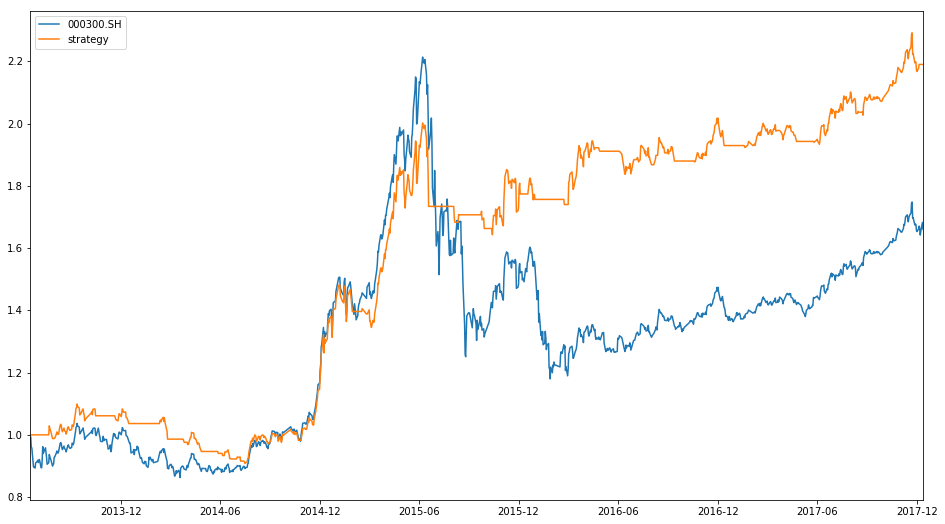

In [256]:
plt.figure(figsize=(16, 9))
(1 + strategy['close'].pct_change()).cumprod().plot(label='000300.SH')
(1 + ret).cumprod().plot(label='strategy')
plt.legend()

In [257]:
metric(ret)

Total return: 118.98%
Annual return: 19.71%
Sharpe ratio: 1.20
Annual volatility: 16.09%
Max drawdown: -17.94%


In [120]:
strategy.to_excel('./strategy.xlsx')